In [1]:
import pandas as pd, datetime
import yfinance as yf
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [2]:
# Download V daily price date

df = yf.download(
    "V", start="2020-03-31", end="2023-03-31", progress=False, auto_adjust=True
)["Close"]
df

Date
2020-03-31    157.881317
2020-04-01    150.032318
2020-04-02    154.226288
2020-04-03    148.797638
2020-04-06    166.034073
                 ...    
2023-03-24    221.039993
2023-03-27    221.809998
2023-03-28    220.330002
2023-03-29    223.300003
2023-03-30    222.360001
Name: Close, Length: 756, dtype: float64

In [3]:
# yahoo finance includes time in date-time for time series, must reset index to remove time for excel output
df1 = df.reset_index()  # move date and time to axis 1 index 0
date = df1["Date"].dt.date  # remove time stamp
ex_dt = df1.iloc[:, 1:]  # create new date only index column
V = ex_dt.set_index(date)  # set date column

V.reset_index(inplace=True)
V.columns = ["ds", "y"]
V

,ds,y
0,2020-03-31,157.881317
1,2020-04-01,150.032318
2,2020-04-02,154.226288
3,2020-04-03,148.797638
4,2020-04-06,166.034073
...,...,...
751,2023-03-24,221.039993
752,2023-03-27,221.809998
753,2023-03-28,220.330002
754,2023-03-29,223.300003


In [4]:
# split the data into training and test sets
train_indices = V["ds"].astype(str) < "2023-03-31"
df_train = V.loc[train_indices].dropna()
df_test = V.loc[~train_indices].reset_index(drop=True)

In [5]:
# set paramets for Meta Prophet algorithm
prophet = Prophet(changepoint_range=0.9)
prophet.add_country_holidays(country_name="US")
prophet.add_seasonality(name="weekly", period=365.25, fourier_order=5)
prophet.fit(df_train)

21:19:32 - cmdstanpy - INFO - Chain [1] start processing
21:19:32 - cmdstanpy - INFO - Chain [1] done processing


<Axes: title={'center': 'V Daily Price Movement'}>

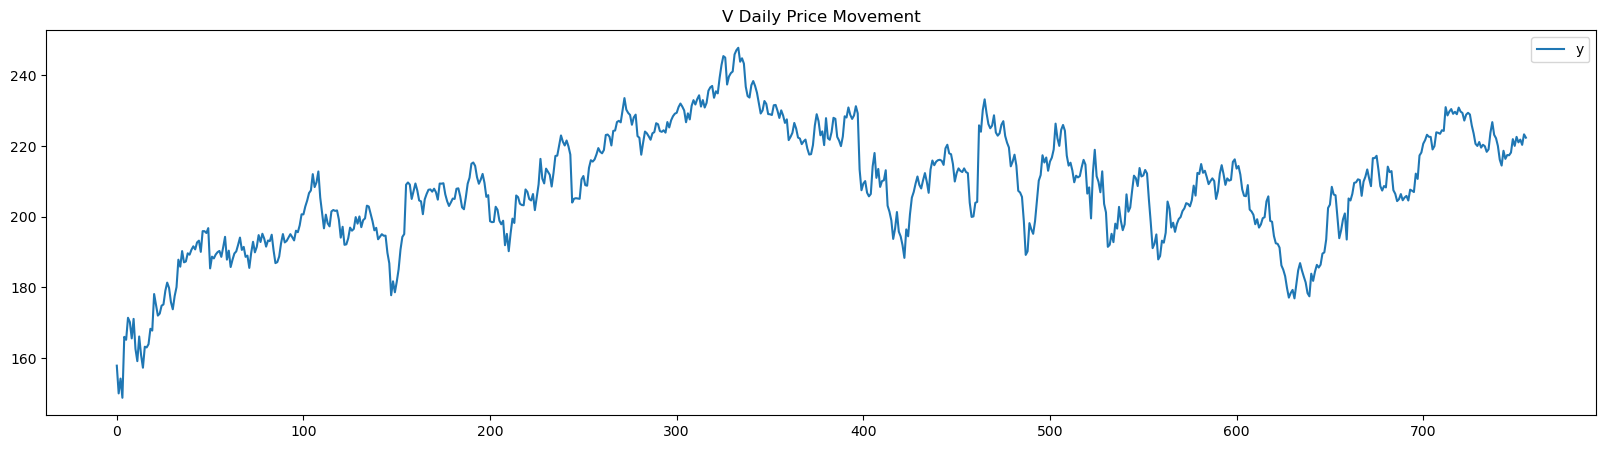

In [6]:
# Original Time Series
V.plot(title="V Daily Price Movement", figsize=(20, 5))

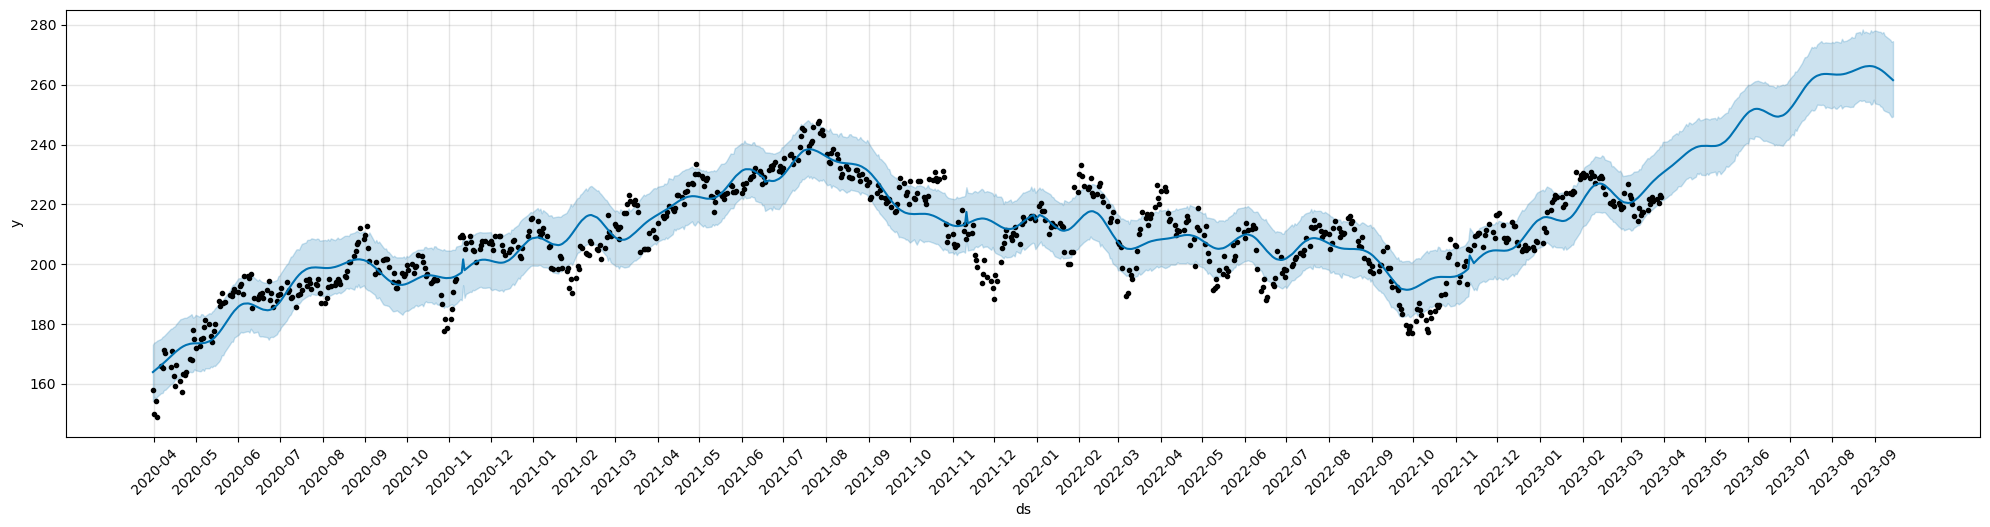

In [7]:
# use the model to make predictions for the specified future date. seasonality is set to consider intra-week non-trading days in the date range chosen
df_future = prophet.make_future_dataframe(periods=120, freq="B")
df_pred = prophet.predict(df_future)
fig = prophet.plot(df_pred, figsize=(20, 5))
months = pd.date_range(V["ds"].min(), df_future["ds"].max(), freq="MS")
plt.xticks(months, [month.strftime("%Y-%m") for month in months], rotation=45)
plt.show()

In [8]:
# show columns from prophet df
df_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper',
       'Juneteenth National Independence Day',
       'Juneteenth National Independence Day_lower',
       'Juneteenth National Independence Day_upper',
       'Juneteenth National Independence Day (Observed)',
       'Juneteenth National Independence Day (Observed)_lower',
       'Juneteenth National Independence Day (Observed)_upper', 'Labor Day',
       'Labor Day_lower', 'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Mart

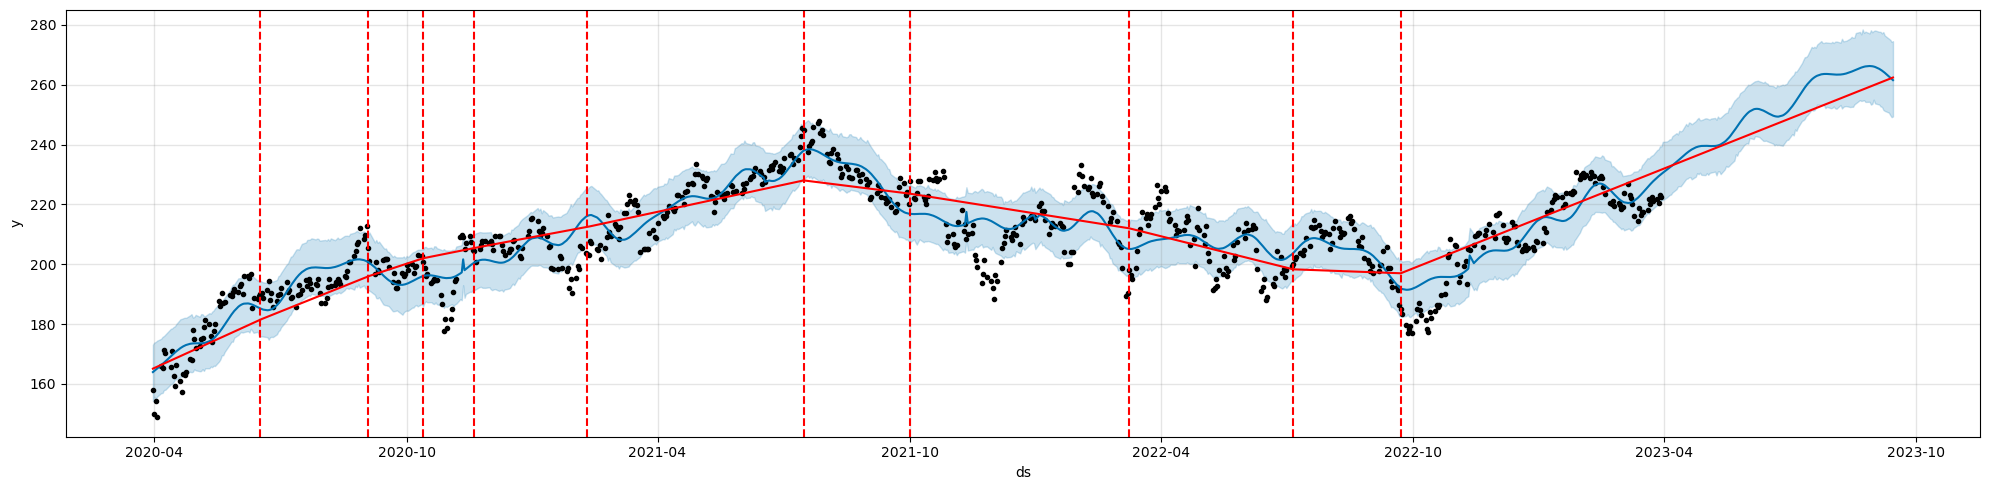

In [9]:
# add change points to predicted timeseries,
fig = prophet.plot(df_pred, figsize=(20, 5))
a = add_changepoints_to_plot(fig.gca(), prophet, df_pred)

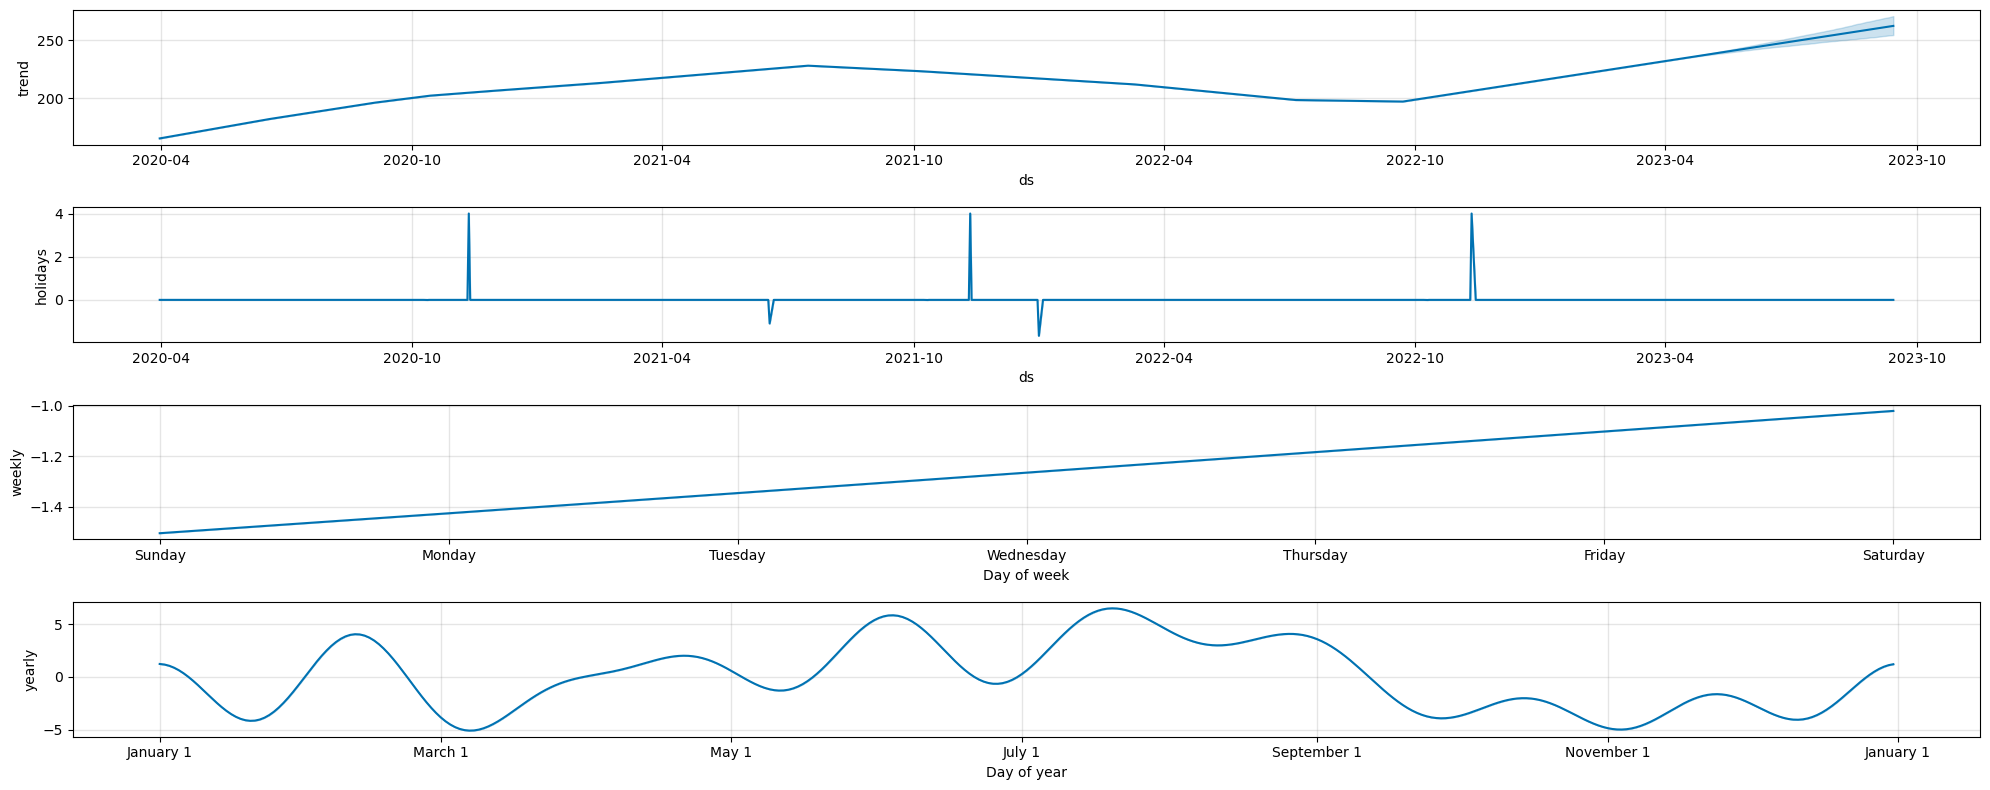

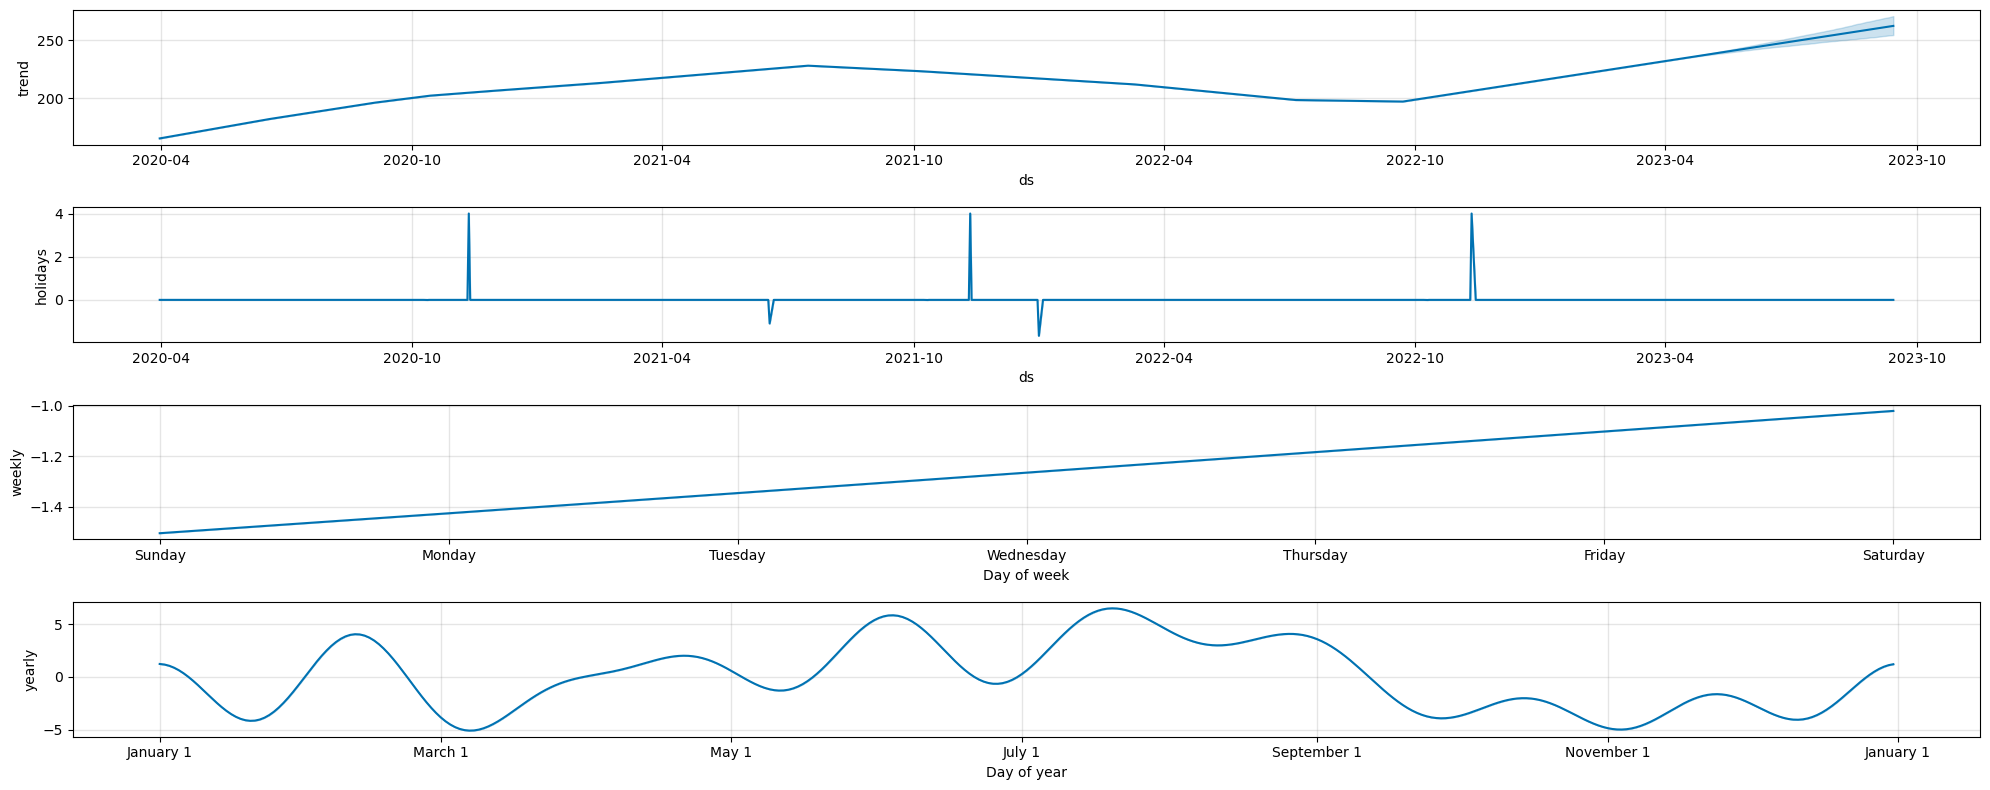

In [10]:
# decompose the timeseries
prophet.plot_components(df_pred, figsize=(20, 8))

In [11]:
# remove seasonality and other unncessary columns generated by prophet algorithm, extract only date series predicted value, upper and lower bounds
SELECTED_COLS = ["ds", "yhat", "yhat_lower", "yhat_upper"]
df_pred = df_pred.loc[:, SELECTED_COLS].reset_index(drop=True)
df_pred = df_pred.set_index("ds")
df_pred

,yhat,yhat_lower,yhat_upper
ds,,,
2020-03-31,163.929679,154.261080,173.101590
2020-04-01,164.308909,155.679708,173.822897
2020-04-02,164.686343,154.853203,173.959611
2020-04-03,165.064819,155.692706,174.415366
2020-04-06,166.229741,156.902363,175.057213
...,...,...,...
2023-09-08,264.036786,251.267964,276.505152
2023-09-11,262.830393,250.689500,275.426455
2023-09-12,262.407603,249.854534,275.060570


In [12]:
# Remove timestamp from df_pred and prepare to merge with original V timeseries

df_pred1 = df_pred.reset_index()  # move date and time to axis 1 index 0
df_pred_dt = df_pred1["ds"].dt.date  # remove time stamp
df_pred_ex_dt = df_pred1.iloc[:, 1:]  # create new date only index column
df_pred_merge = df_pred_ex_dt.set_index(df_pred_dt)  # set date column

df_pred_merge.reset_index(inplace=True)
df_pred_merge

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-31,163.929679,154.261080,173.101590
1,2020-04-01,164.308909,155.679708,173.822897
2,2020-04-02,164.686343,154.853203,173.959611
3,2020-04-03,165.064819,155.692706,174.415366
4,2020-04-06,166.229741,156.902363,175.057213
...,...,...,...,...
871,2023-09-08,264.036786,251.267964,276.505152
872,2023-09-11,262.830393,250.689500,275.426455
873,2023-09-12,262.407603,249.854534,275.060570
874,2023-09-13,261.982827,249.176533,274.358405


In [13]:
# Merge original time series with predications and tested data & rename columns to prepare for plotting

combined_df = pd.merge(
    V, df_pred_merge[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="outer"
)

combined_df = combined_df.rename(
    columns={
        "ds": "Date",
        "y": "Actual",
        "yhat": "Predicted",
        "yhat_lower": "Lower Bound",
        "yhat_upper": "Upper Bound",
    }
)

combined_df.set_index("Date", inplace=True)
combined_df

,Actual,Predicted,Lower Bound,Upper Bound
Date,,,,
2020-03-31,157.881317,163.929679,154.261080,173.101590
2020-04-01,150.032318,164.308909,155.679708,173.822897
2020-04-02,154.226288,164.686343,154.853203,173.959611
2020-04-03,148.797638,165.064819,155.692706,174.415366
2020-04-06,166.034073,166.229741,156.902363,175.057213
...,...,...,...,...
2023-09-08,NaN,264.036786,251.267964,276.505152
2023-09-11,NaN,262.830393,250.689500,275.426455
2023-09-12,NaN,262.407603,249.854534,275.060570


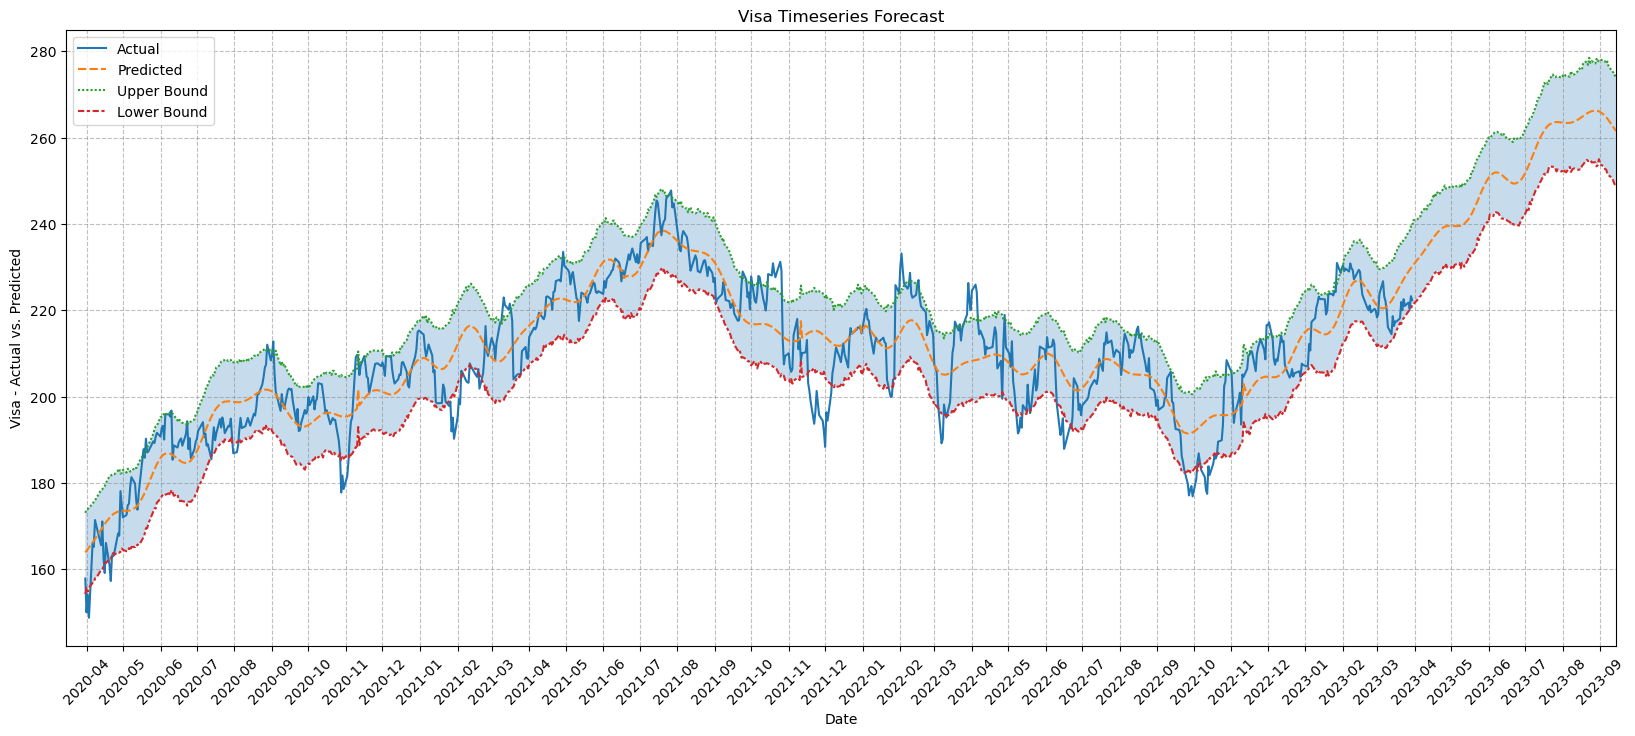

In [14]:
# set up plotting parameters and generate plot

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

PLOT_COLS = [
    "Actual",
    "Predicted",
    "Upper Bound",
    "Lower Bound",
]
sns.lineplot(data=combined_df[PLOT_COLS], ax=ax)
ax.fill_between(
    combined_df.index,
    combined_df["Lower Bound"],
    combined_df["Upper Bound"],
    alpha=0.25,
)

# Format x-axis ticks
date_form = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_tick_params(rotation=45)

# Set x-axis limits
ax.set_xlim([datetime.date(2020, 3, 15), combined_df.index.max()])

# Add gridlines
ax.grid(True, which="major", axis="both", linestyle="--", color="gray", alpha=0.5)

ax.set(
    title="Visa Timeseries Forecast",
    xlabel="Date",
    ylabel="Visa - Actual vs. Predicted",
)

plt.show()

In [15]:
# Display the expected value as of the end of the forecasted timeseries
forecasted_value = combined_df.iloc[-1, 1]
print("Forecasted value for 2023-09-14:", forecasted_value)

Forecasted value for 2023-09-14: 261.5612767234075
